In [ ]:
! pip install pyhht

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
# Mengakses lokasi penyimpanan berkas pada Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from pyhht.emd import EMD
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
def plot_imfs(signal, imfs, time_samples=None, fignum=None):
    if time_samples is None:
        time_samples = np.arange(signal.shape[0])

    n_imfs = imfs.shape[0]

    plt.figure(num=fignum, figsize=(16, 25))
    axis_extent = max(np.max(np.abs(imfs[:-1, :]), axis=0))

    # Plot original signal
    ax = plt.subplot(n_imfs + 1, 1, 1)
    ax.plot(time_samples, signal)
    ax.axis([time_samples[0], time_samples[-1], signal.min(), signal.max()])
    ax.tick_params(which='both')
    ax.grid(True)
    ax.set_ylabel('Signal')
    ax.set_title('Empirical Mode Decomposition')

    # Plot the IMFs
    for i in range(n_imfs - 1):
        print(i + 2)
        ax = plt.subplot(n_imfs + 1, 1, i + 2)
        ax.plot(time_samples, imfs[i, :])
        ax.axis([time_samples[0], time_samples[-1], -axis_extent, axis_extent])
        ax.tick_params(which='both')
        ax.grid(True)
        ax.set_ylabel('imf' + str(i + 1))
    
    plt.show()
    plt.close()

    plt.figure(figsize=(16, 5))
    plt.plot(time_samples, imfs[-1, :], 'r')
    
    plt.axis('tight')
    plt.tick_params(which='both')
    plt.grid(True)
    plt.ylabel('res.')

    line = plt.gca().lines[0]
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    plt.show()

    data_res = pd.DataFrame(index=None)
    data_res["X"] = xdata
    data_res["Y"] = ydata.astype("int64")
    data_res["SIGNAL"] = signal.astype("int64")
    print(data_res)
    data_res.to_csv("data_res.txt", index=None)

In [ ]:
# Menampilkan struktur tabel (baris, kolom, dan tipe data) pada file data
import pandas as pd
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/.../data/new_data_ok.csv", engine="python")[12:]
new_data = data.copy()
new_data["MONTH"] = new_data["MONTH"].astype("datetime64")
new_data = new_data.set_index("MONTH")
bps, trends = new_data.BPS, new_data.TRENDS
new_data.drop(columns=["BPS", "TRENDS", "Unnamed: 0", "DELAY0"], inplace=True)
new_data = new_data.astype("int64")
print(new_data.dtypes)
new_data

DELAY1     int64
DELAY2     int64
DELAY3     int64
DELAY4     int64
DELAY5     int64
DELAY6     int64
DELAY7     int64
DELAY8     int64
DELAY9     int64
DELAY10    int64
DELAY11    int64
DELAY12    int64
dtype: object


,DELAY1,DELAY2,DELAY3,DELAY4,DELAY5,DELAY6,DELAY7,DELAY8,DELAY9,DELAY10,DELAY11,DELAY12
MONTH,,,,,,,,,,,,
2009-01-01,305767,266175,299943,274428,317583,314608,314608,396508,274428,576583,219303,291312
2009-02-01,329623,305767,266175,299943,274428,317583,314608,314608,396508,274428,576583,219303
2009-03-01,302848,329623,305767,266175,299943,274428,317583,314608,314608,396508,274428,576583
2009-04-01,458752,302848,329623,305767,266175,299943,274428,317583,314608,314608,396508,274428
2009-05-01,776223,458752,302848,329623,305767,266175,299943,274428,317583,314608,314608,396508
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,297052,533232,305767,444528,548800,655452,386575,448063,427063,434007,568575,473200
2021-09-01,416752,297052,533232,305767,444528,548800,655452,386575,448063,427063,434007,568575
2021-10-01,544887,416752,297052,533232,305767,444528,548800,655452,386575,448063,427063,434007


# Pembersihan Noise Menggunakan HHT

[ 291312  219303  576583  274428  396508  314608  314608  317583  274428
  299943  266175  305767  329623  302848  458752  776223  681408  592767
  694575  560623  651175  857500  592767  338800  979132  776223  813967
  685783 1228927  540988  506527  707868  529375  576583  406567  862407
  887151  703423  462343  646912  794983  617463 1097712  469567  852606
  887151  707868  685783 1005487  664048  799708  638428  799708  804447
  818747  672700  651175  809200  725788  540988  560623  721287  790272
  690172 1228927 1037575  847728  877212  907200  813967  762300  917308
  818747 1270332 1092175 1103263  927472  892143  872263 1404928  994903
  725788 1312423 1053808 1461943 1037575 1016127 1064700 1182447 1070167
  804447 1223068  867328  942823  963487 1053808 1276303 1081143 1392412
 1108828 1240687  989632 1010800 1153852 1005487 1165248  882175 1417500
 1306368 1205575 1205575 1442812 1639792 1258432 1417500 1820700 1633023
 1361367 1936732 1097712 1792252 1673847 1468348 13

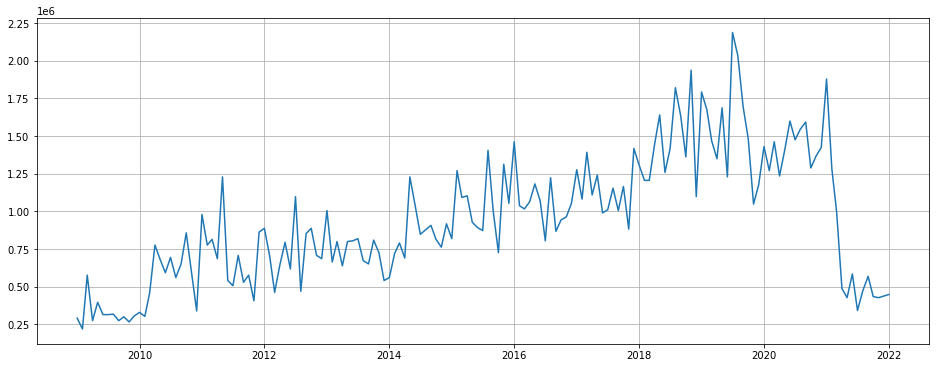

In [ ]:
# Membuat dataset menjadi grafik
line1 = np.array(data["MONTH"].astype("datetime64"))
modes = np.array(new_data["DELAY12"])
print(modes)
plt.figure(figsize=(16, 6))
plt.plot_date(line1, modes, "-")
plt.grid()
plt.show()

2
3
4
5


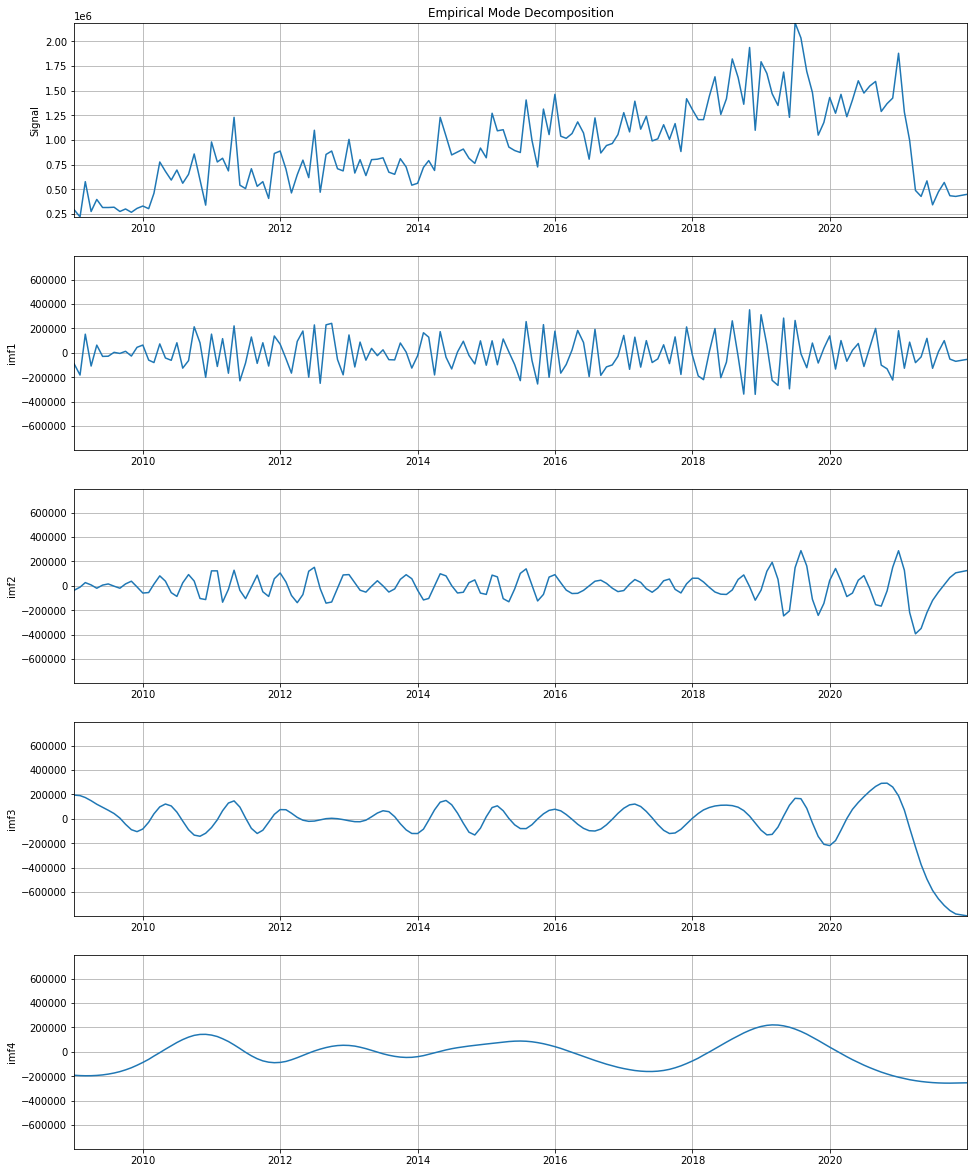

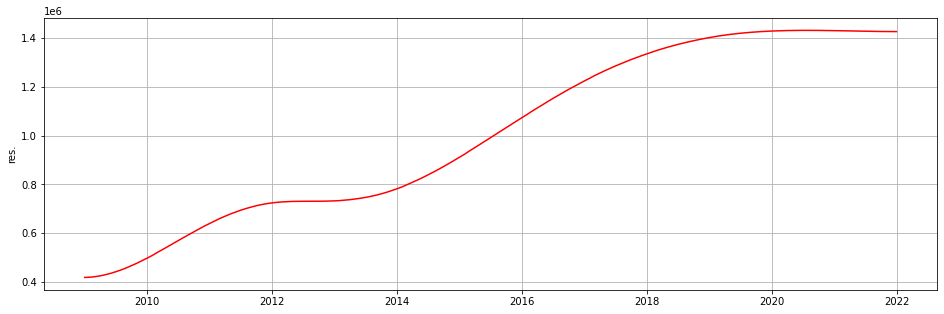

             X        Y  SIGNAL
0   2009-01-01   417831  291312
1   2009-02-01   418780  219303
2   2009-03-01   420960  576583
3   2009-04-01   424360  274428
4   2009-05-01   428912  396508
..         ...      ...     ...
151 2021-08-01  1428295  473200
152 2021-09-01  1427942  568575
153 2021-10-01  1427639  434007
154 2021-11-01  1427394  427063
155 2021-12-31  1427203  448063

[156 rows x 3 columns]


In [ ]:
# Pemprosesan Noise dan Hasil Pembersihan
decompos = EMD(modes)
imfs = decompos.decompose()
plot_imf = plot_imfs(modes, imfs, line1)

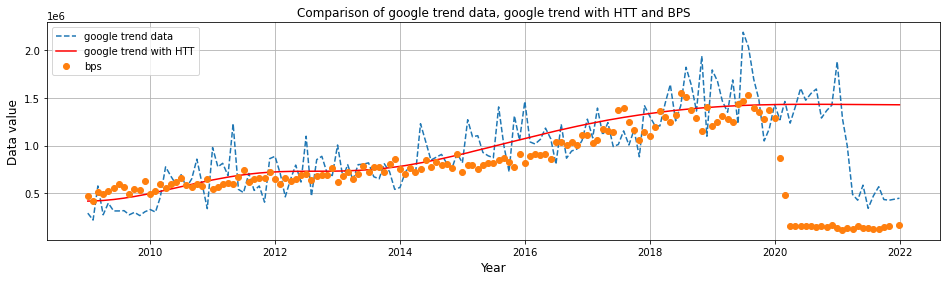

In [ ]:
# Gabungan dataset bps, google trends, dan hht
# GOOGLE TREND Warna Biru
# BPS Warna Oren
# HHT WArna Merah
data_res = pd.read_csv("data_res.txt").set_index(line1)
hht_res = data_res["Y"]
real_signal = data_res["SIGNAL"]
plt.figure(figsize=(16, 4))
plt.plot(real_signal, '--')
plt.plot(hht_res, 'r')
plt.plot(bps, 'o')
#memberi judul table
plt.title('Comparison of google trend data, google trend with HTT and BPS', size='large')
plt.xlabel('Year', size='large')
plt.ylabel('Data value', size='large')
plt.legend(['google trend data','google trend with HTT','bps'])
plt.grid()
plt.show()

In [ ]:
hht_res_big = []
for line in hht_res:
    hht_res_big.append(int(line))

compare = pd.DataFrame([hht_res_big, bps], ["hht", "bps"]).transpose()
compare

,hht,bps
0,417831,473165
1,418780,421555
2,420960,511314
3,424360,487121
4,428912,521735
...,...,...
151,1428295,124751
152,1427942,124071
153,1427639,148645
154,1427394,153199


# Proses Pengujian Atau Prediksi LSTM

In [ ]:
# Selanjutnya Proses Prediski
# Menampilkan struktur tabel (hht, bps, dan bulan)
dataset = compare
bulan = pd.read_csv("/content/drive/My Drive/Colab Notebooks/.../data/new_data_ok.csv", engine="python")[12:].reset_index()
dataset["MONTH"] = bulan["MONTH"].str.replace("-", "")
dataset["MONTH"] = dataset["MONTH"].str[:6]
dataset["REAL"] = modes
dataset

,hht,bps,MONTH,REAL
0,417831,473165,200901,291312
1,418780,421555,200902,219303
2,420960,511314,200903,576583
3,424360,487121,200904,274428
4,428912,521735,200905,396508
...,...,...,...,...
151,1428295,124751,202108,473200
152,1427942,124071,202109,568575
153,1427639,148645,202110,434007
154,1427394,153199,202111,427063


In [ ]:
# Memanggil data Tahun 2021
samplea = dataset.drop(columns=["REAL"]).astype("int32")

sample = dataset.drop(columns=["bps","REAL"]).astype("int32")
sample1 = dataset.drop(columns=["bps","hht"]).astype("int32")
value = dataset["bps"].astype("int32")

sample_traina = np.array(sample[:144]).reshape(len(samplea[:144]), 2)

sample_train = np.array(sample[:144]).reshape(len(sample[:144]), 2)
sample_train1 = np.array(sample1[:144]).reshape(len(sample1[:144]), 2)
value_train = np.array(value[:144])

sample_testa = np.array(sample[144:]).reshape(len(samplea[144:]), 2)

sample_test = np.array(sample[144:]).reshape(len(sample[144:]), 2)
sample_test1 = np.array(sample1[144:]).reshape(len(sample1[144:]), 2)
value_test = np.array(value[144:])

print(sample_test)
print(value_test)

[[1431217  202101]
 [1430830  202102]
 [1430414  202103]
 [1429981  202104]
 [1429541  202105]
 [1429105  202106]
 [1428686  202107]
 [1428295  202108]
 [1427942  202109]
 [1427639  202110]
 [1427394  202111]
 [1427203  202112]]
[137230 115765 130933 125001 152604 137247 135438 124751 124071 148645
 153199 163619]


In [ ]:
# Membangun arsitektur LSTM Forecasting yang asli
lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max(sample["hht"]+1), output_dim=100, trainable=False, input_length=2),
    tf.keras.layers.LSTM(100, time_major=True, return_sequences=True, activation="exponential"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="exponential")
], name="LSTM1")

lstm1.compile(optimizer="RMSprop", loss="mean_absolute_percentage_error", metrics=["mean_absolute_percentage_error"])
lstm1.summary()

Model: "LSTM1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2, 100)            143232300 
                                                                 
 lstm (LSTM)                 (None, 2, 100)            80400     
                                                                 
 dense (Dense)               (None, 2, 1)              101       
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 143,312,804
Trainable params: 80,504
Non-trainable params: 143,232,300
_________________________________________________________________


In [ ]:
#pelatihan dengan epoch 350 terbaik untuk data BPS
lstm1.fit(sample_traina, value_train, batch_size=1, epochs=350, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/350
144/144 [==============================] - 5s 4ms/step - loss: 52.8984 - mean_absolute_percentage_error: 52.8984
Epoch 2/350
144/144 [==============================] - 1s 4ms/step - loss: 23.2580 - mean_absolute_percentage_error: 23.2580
Epoch 3/350
144/144 [==============================] - 1s 4ms/step - loss: 24.1746 - mean_absolute_percentage_error: 24.1746
Epoch 4/350
144/144 [==============================] - 1s 4ms/step - loss: 21.7966 - mean_absolute_percentage_error: 21.7966
Epoch 5/350
144/144 [==============================] - 1s 4ms/step - loss: 22.7768 - mean_absolute_percentage_error: 22.7768
Epoch 6/350
144/144 [==============================] - 1s 4ms/step - loss: 21.6220 - mean_absolute_percentage_error: 21.6220
Epoch 7/350
144/144 [==============================] - 1s 4ms/step - loss: 21.3574 - mean_absolute_percentage_error: 21.3574
Epoch 8/350
144/144 [==============================] - 1s 4ms/step - loss: 20.3345 - mean_absolute_percentage_error: 20.3345


In [ ]:
# Membangun arsitektur LSTM Forecasting yang belum di HHT ( TREND )
lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max(sample["hht"]+1), output_dim=100, trainable=False, input_length=2),
    tf.keras.layers.LSTM(100, time_major=True, return_sequences=True, activation="exponential"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="exponential")
], name="LSTM1")

lstm1.compile(optimizer="RMSprop", loss="mean_absolute_percentage_error", metrics=["mean_absolute_percentage_error"])
lstm1.summary()

Model: "LSTM1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2, 100)            143232300 
                                                                 
 lstm_1 (LSTM)               (None, 2, 100)            80400     
                                                                 
 dense_2 (Dense)             (None, 2, 1)              101       
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 143,312,804
Trainable params: 80,504
Non-trainable params: 143,232,300
_________________________________________________________________


In [ ]:
#pelatihan dengan epoch 350
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=350, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/350
144/144 [==============================] - 2s 4ms/step - loss: 34.0195 - mean_absolute_percentage_error: 34.0195
Epoch 2/350
144/144 [==============================] - 1s 4ms/step - loss: 23.3001 - mean_absolute_percentage_error: 23.3001
Epoch 3/350
144/144 [==============================] - 1s 4ms/step - loss: 22.9829 - mean_absolute_percentage_error: 22.9829
Epoch 4/350
144/144 [==============================] - 1s 4ms/step - loss: 23.8888 - mean_absolute_percentage_error: 23.8888
Epoch 5/350
144/144 [==============================] - 1s 4ms/step - loss: 23.8714 - mean_absolute_percentage_error: 23.8714
Epoch 6/350
144/144 [==============================] - 1s 4ms/step - loss: 21.1982 - mean_absolute_percentage_error: 21.1982
Epoch 7/350
144/144 [==============================] - 1s 4ms/step - loss: 23.1322 - mean_absolute_percentage_error: 23.1322
Epoch 8/350
144/144 [==============================] - 1s 4ms/step - loss: 20.8226 - mean_absolute_percentage_error: 20.8226


In [ ]:
# Membangun arsitektur LSTM Forecasting yang di HHT
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max(sample["hht"]+1), output_dim=100, trainable=False, input_length=2),
    tf.keras.layers.LSTM(100, time_major=True, return_sequences=True, activation="exponential"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="exponential")
], name="LSTM")

lstm.compile(optimizer="RMSprop", loss="mean_absolute_percentage_error", metrics=["mean_absolute_percentage_error"])
lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2, 100)            143232300 
                                                                 
 lstm_2 (LSTM)               (None, 2, 100)            80400     
                                                                 
 dense_4 (Dense)             (None, 2, 1)              101       
                                                                 
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 143,312,804
Trainable params: 80,504
Non-trainable params: 143,232,300
_________________________________________________________________


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 300
lstm.fit(sample_train, value_train, batch_size=1, epochs=300, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/300
144/144 [==============================] - 2s 4ms/step - loss: 68.7767 - mean_absolute_percentage_error: 68.7767
Epoch 2/300
144/144 [==============================] - 1s 4ms/step - loss: 27.0531 - mean_absolute_percentage_error: 27.0531
Epoch 3/300
144/144 [==============================] - 1s 4ms/step - loss: 24.7672 - mean_absolute_percentage_error: 24.7672
Epoch 4/300
144/144 [==============================] - 1s 4ms/step - loss: 26.2109 - mean_absolute_percentage_error: 26.2109
Epoch 5/300
144/144 [==============================] - 1s 4ms/step - loss: 26.2766 - mean_absolute_percentage_error: 26.2766
Epoch 6/300
144/144 [==============================] - 1s 4ms/step - loss: 26.5173 - mean_absolute_percentage_error: 26.5173
Epoch 7/300
144/144 [==============================] - 1s 4ms/step - loss: 22.8103 - mean_absolute_percentage_error: 22.8103
Epoch 8/300
144/144 [==============================] - 1s 4ms/step - loss: 26.8588 - mean_absolute_percentage_error: 26.8588


In [ ]:
# Memprediksi tahun 2021 kemudian menampilkannya BPS
test_predict0 = lstm1.predict(sample_testa, batch_size=1, use_multiprocessing=True)
predict0 = []
for i in test_predict0:
    predict0.append(i)

predict0

[array([270094.2], dtype=float32),
 array([181607.12], dtype=float32),
 array([291717.72], dtype=float32),
 array([813933.9], dtype=float32),
 array([442043.53], dtype=float32),
 array([303312.12], dtype=float32),
 array([470908.4], dtype=float32),
 array([261414.53], dtype=float32),
 array([725961.06], dtype=float32),
 array([616138.6], dtype=float32),
 array([180454.05], dtype=float32),
 array([1183755.2], dtype=float32)]

In [ ]:
# Memprediksi tahun 2021 kemudian menampilkannya yang belum di HHT( TREND )
test_predict1 = lstm1.predict(sample_test1, batch_size=1, use_multiprocessing=True)
predict1 = []
for i in test_predict1:
    predict1.append(i)

predict1

[array([593688.06], dtype=float32),
 array([365899.12], dtype=float32),
 array([106939.55], dtype=float32),
 array([558922.2], dtype=float32),
 array([809108.44], dtype=float32),
 array([190537.67], dtype=float32),
 array([195216.56], dtype=float32),
 array([603681.2], dtype=float32),
 array([751018.3], dtype=float32),
 array([208400.34], dtype=float32),
 array([193452.94], dtype=float32),
 array([903064.8], dtype=float32)]

In [ ]:
# Memprediksi tahun 2021 kemudian menampilkannya yang di HHT
test_predict = lstm.predict(sample_test, batch_size=1, use_multiprocessing=True)
predict = []
for i in test_predict:
    predict.append(i)

predict

[array([706480.6], dtype=float32),
 array([306613.9], dtype=float32),
 array([404492.3], dtype=float32),
 array([529828.4], dtype=float32),
 array([1137227.9], dtype=float32),
 array([393146.28], dtype=float32),
 array([142773.22], dtype=float32),
 array([387198.03], dtype=float32),
 array([696347.25], dtype=float32),
 array([196419.75], dtype=float32),
 array([219909.], dtype=float32),
 array([351578.5], dtype=float32)]

In [ ]:
compare = pd.DataFrame([value_test,predict0, predict1, predict], ["ACTUAL", "LSTM (BPS Data)","LSTM (BPS +GT)", "HHT – LSTM (BPS +GT)"]).transpose().set_index(line1[-12:])
compare

,ACTUAL,LSTM (BPS Data),LSTM (BPS +GT),HHT – LSTM (BPS +GT)
2021-01-01,137230,[270094.2],[593688.06],[706480.6]
2021-02-01,115765,[181607.12],[365899.12],[306613.9]
2021-03-01,130933,[291717.72],[106939.55],[404492.3]
2021-04-01,125001,[813933.9],[558922.2],[529828.4]
2021-05-01,152604,[442043.53],[809108.44],[1137227.9]
2021-06-01,137247,[303312.12],[190537.67],[393146.28]
2021-07-01,135438,[470908.4],[195216.56],[142773.22]
2021-08-01,124751,[261414.53],[603681.2],[387198.03]
2021-09-01,124071,[725961.06],[751018.3],[696347.25]
2021-10-01,148645,[616138.6],[208400.34],[196419.75]


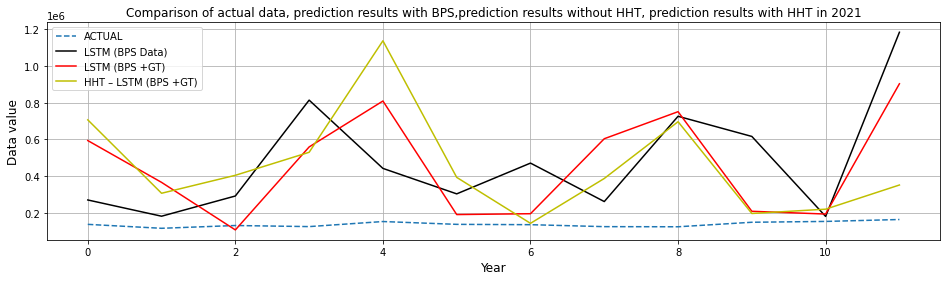

In [ ]:
##coba membuat grafik (wajib ada)
plt.figure(figsize=(16, 4))
plt.plot(value_test, '--')
plt.plot(predict0,'00')
plt.plot(predict1, 'r')
plt.plot(predict, '-y')
#memberi judul table
plt.title('Comparison of actual data, prediction results with BPS,prediction results without HHT, prediction results with HHT in 2021', size='large')
plt.xlabel('Year', size='large')
plt.ylabel('Data value', size='large')
plt.legend(["ACTUAL", "LSTM (BPS Data)","LSTM (BPS +GT)", "HHT – LSTM (BPS +GT)"])
plt.grid()
plt.show()

In [ ]:
# Hasil RMSE dan MAPE ditahun 2021
mape0 = []
rmse0 = []
mape = []
mape1 = []
rmse = []
rmse1 = []
for i in range(len(sample_test)):
    mape0.append((abs((value_test[i] - predict[i]) / value_test[i]) * 100).tolist())
    rmse0.append(np.sqrt((value_test[i] - predict[i])**2).tolist())

    mape.append((abs((value_test[i] - predict[i]) / value_test[i]) * 100).tolist())
    rmse.append(np.sqrt((value_test[i] - predict[i])**2).tolist())

    mape1.append((abs((value_test[i] - predict1[i]) / value_test[i]) * 100).tolist())
    rmse1.append(np.sqrt((value_test[i] - predict1[i])**2).tolist())

mape0 = [j for sub in mape1 for j in sub]
rmse0 = [j for sub in rmse1 for j in sub]
eval = pd.DataFrame()
eval["MAPE LSTM"] = mape0
eval["RMSE LSTM"] = rmse0

mape1 = [j for sub in mape1 for j in sub]
rmse1 = [j for sub in rmse1 for j in sub]
eval = pd.DataFrame()
eval["MAPE LSTM"] = mape1
eval["RMSE LSTM"] = rmse1

mape = [j for sub in mape for j in sub]
rmse = [j for sub in rmse for j in sub]
eval["MAPE HHT – LSTM"] = mape
eval["RMSE HHT – LSTM"] = rmse

eval

,MAPE LSTM,RMSE LSTM,MAPE HHT – LSTM,RMSE HHT – LSTM
0,332.622650,456458.062500,414.815000,569250.62500
1,216.070596,250134.125000,164.858901,190848.90625
2,18.324985,23993.453125,208.930760,273559.31250
3,347.134173,433921.187500,323.859309,404827.37500
4,430.201330,656504.437500,645.214985,984623.87500
5,38.828296,53290.671875,186.451639,255899.28125
6,44.137216,59778.562500,5.415924,7335.21875
7,383.908897,478930.187500,210.376695,262447.03125
8,505.313339,626947.312500,461.249003,572276.25000
9,40.200036,59755.343750,32.140166,47774.75000


In [ ]:
mapea0=np.average(eval['MAPE LSTM'])
rmsea0 = np.average(eval['RMSE LSTM'])
print("MAPE LSTM", mapea0)
print("RMSE LSTM", rmsea0)

mapea1=np.average(eval['MAPE LSTM'])
rmsea1 = np.average(eval['RMSE LSTM'])
print("MAPE LSTM", mapea1)
print("RMSE LSTM", rmsea1)

mapea=np.average(eval['MAPE HHT – LSTM'])
rmsea = np.average(eval['RMSE HHT – LSTM'])
print("MAPE HHT – LSTM", mapea)
print("RMSE HHT – LSTM", rmsea)

MAPE LSTM 236.24571767613475
RMSE LSTM 323284.4244791667
MAPE LSTM 236.24571767613475
RMSE LSTM 323284.4244791667
MAPE HHT – LSTM 234.31111510217434
RMSE HHT – LSTM 318626.0104166667
